In [ ]:
pip install scikit-learn-extra

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.4 MB/s eta 0:00:00


In [ ]:
!pip install --quiet pyspark

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import sys
import time
import random
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from __future__ import division
import matplotlib.pyplot as plt
from numpy.linalg import norm
from sklearn.cluster import KMeans
input = "/content/gdrive/My Drive/Iris.csv"

## Sequential K Means clustering

In [ ]:
class K_Means(object):
    def __init__(self, n_clusters, max_iter):
        self.n_clusters = n_clusters
        self.max_iter = max_iter

    # Function to assign points to a cluster
    def assign_points_to_cluster(self, X):
        self.labels_ = [self._nearest(self.cluster_centers_, x) for x in X]
        indices=[]
        for j in range(self.n_clusters):
            cluster=[]
            for i, l in enumerate(self.labels_):
                if l==j: cluster.append(i)
            indices.append(cluster)
        X_by_cluster = [X[i] for i in indices]
        return X_by_cluster

    # Function to randomly select initial centroids
    def initial_centroid(self, X):
        initial = np.random.permutation(X.shape[0])[:self.n_clusters]
        return X[initial]

    # Function to update centroids and repeat assign_points_to_cluster until convergence or max_iter is reached
    def fit(self, X):
        self.cluster_centers_ = self.initial_centroid(X)
        for i in range(self.max_iter):
            X_by_cluster = self.assign_points_to_cluster(X)
            # calculating the new centroids
            new_centers=[c.sum(axis=0)/len(c) for c in X_by_cluster]
            new_centers = [arr.tolist() for arr in new_centers]
            old_centers=self.cluster_centers_
            # if the new centroids are the same as the old centroids then the algorithm has converged
            if np.all(new_centers == old_centers):
                self.number_of_iter=i
                break;
            else:
                self.cluster_centers_ = new_centers
        self.number_of_iter=i
        return self

    # Function to calculate the minimum euclidean distance
    def _nearest(self, clusters, x):
        return np.argmin([self._distance(x, c) for c in clusters])

    # Function to calculate euclidean distance between two points
    def _distance(self, a, b):
        return np.sqrt(((a - b)**2).sum())

    # Function to return predicted cluster for each point
    def predict(self, X):
      return self.labels_

## Parallelized K Means Clustering

In [ ]:
from pyspark import SparkContext, SparkConf

In [ ]:
try:
    sc = SparkContext.getOrCreate()
except Exception as e:
    print("An error occurred while trying to create or get SparkContext:", str(e))
    sc = None

if sc is None:
    conf = SparkConf().setAppName("KMeansClustering_iris").setMaster("local")
    sc = SparkContext(conf=conf)

In [ ]:
import numpy as np

'''
Function to compute centroids for clusters in an RDD.
Returns an RDD of the structure: (cluster_id, [centroid_coordinates]).
  - points : rdd of iterables (n dimensions)
  - cluster_ids : rdd with the same number of samples as "points" that contains the ids of their clusters
'''
def compute_centroids(points, cluster_ids):
  # Creating an rdd containing elements with the strucuture : cluster_id, [point_f1, ... , point_fn]
  # fi : ith feature
  combined_rdd = cluster_ids.zip(points)

  # Calculating the sum of the points of each cluster
  # sum_by_cluster_id has the following structure : cluster_id, [cluster_sum_f1, ..., cluster_sum_fn]
  sum_by_cluster_id = combined_rdd.reduceByKey(lambda x,y : np.sum([x, y], axis=0))

  # Count the number of points in each cluster.
  # A third rdd : cluster_id, nb_elements_cluster
  count_by_cluster_id = combined_rdd.mapValues(lambda v: 1).reduceByKey(lambda x,y : x+y)

  # Compute the centroid for each cluster : [cluster_sum_f1, ..., cluster_sum_fn] / nb_elements_cluster
  # Returns an rdd with the structure : (cluster_id, [mean_x1, ..., mean_xn])
  # The vector represents the centroid of the cluster
  centroids_rdd = sum_by_cluster_id.join(count_by_cluster_id).mapValues(lambda x: x[0]/x[1])

  return centroids_rdd

In [ ]:
from numpy.linalg import norm
from scipy import spatial

'''
Computes the distance of each point to the different clusters given a certain metric
  - point_value : the point vector [point_f1, ..., point_fn]
  - clusters_centroids : [clusted_id, [cluster_f1, ..., clusted_fn]]
  - metric [optional] : Takes two values ('squared_distances' for the euclidean metric, 'cos_sim' for the consine_similarity)
'''
def compute_distance(point_value, clusters_centroids, metric='squared_distances'):
  comp_dist = []

  if metric=='cos_sim':
      for m in clusters_centroids:
          # m[0] : id of the cluster
          # m[1] : mean vector (centroid) of the cluster
          comp_dist.append(1 - spatial.distance.cosine(np.array(point_value), np.array(m[1])))
  else:
      for m in clusters_centroids:
          # m[0] : id of the cluster
          # m[1] : mean vector (centroid) of the cluster
          comp_dist.append(norm(np.array(point_value)-np.array(m[1])))

  return comp_dist

In [ ]:
'''
Assigns each point to the closest cluster
  - points : rdd of iterables (n dimensions)
  - centroids : rdd with elements of structure : clusted_id, [centroid_coordinate]
  - metric [optional] : Takes two values ('squared_distances' for the euclidean metric, 'cos_sim' for the consine_similarity)
  '''
def assign_clusters(points, centroids, metric='squared_distances'):

  # Collecting the centroids as a python list (from the nodes to the driver)
  list_centroids = centroids.collect()

  # Broadcasting the variable to access it from inside the map
  list_centroidsB = sc.broadcast(list_centroids)

  distances_rdd = points.map(lambda x: compute_distance(x, list_centroidsB.value, metric))

  assign_rdd = distances_rdd.map(lambda x : np.argmin(x, axis=0))
  return assign_rdd

In [ ]:
def initialize_kmeans(n_clusters, data, factor=10):
  nb_elements = n_clusters*factor
  sample = data.take(nb_elements)
  rdn_number = 0
  centroides = []

  for i in range(n_clusters):
    rdn_number = random.randint(0, len(sample)-1)
    centroides.append([i, sample[rdn_number]])
  return sc.parallelize(centroides)

In [ ]:
def custom_kmeans(n_clusters, data, factor=15, maxIter=1000, metric='squared_distances'):
  # Initialization
  centroides = initialize_kmeans(n_clusters, data, factor)
  stop = False
  i=0
  while stop==False and i<maxIter:
    assigned_clusters = assign_clusters(data, centroides, metric)
    new_centro = compute_centroids(data, assigned_clusters)
    if i==0:
        prev_centro_ram = pd.DataFrame([x[1] for x in centroides.collect()])
    else:
        prev_centro_ram = pd.DataFrame([x[1].tolist() for x in centroides.collect()])

    new_centro_ram = pd.DataFrame([x[1].tolist() for x in new_centro.collect()])
    if new_centro_ram.equals(prev_centro_ram):
      stop = True
    else:
      centroides = new_centro
      i+=1

  return new_centro, assigned_clusters

## Comparison

In [ ]:
data = pd.read_csv(input)

In [ ]:
data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [ ]:
del data['Species']

In [ ]:
del data['Id']

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SepalLengthCm  150 non-null    float64
 1   SepalWidthCm   150 non-null    float64
 2   PetalLengthCm  150 non-null    float64
 3   PetalWidthCm   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


In [ ]:
data.describe()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [ ]:
data.columns

Index(['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm'], dtype='object')

iteration - 100
iteration - 150
iteration - 200
iteration - 250
iteration - 300
iteration - 350


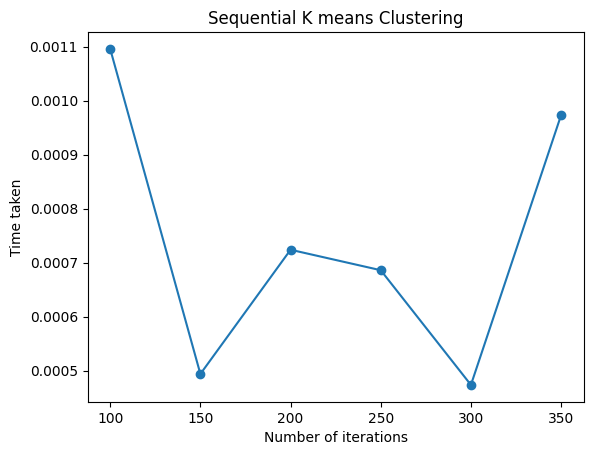

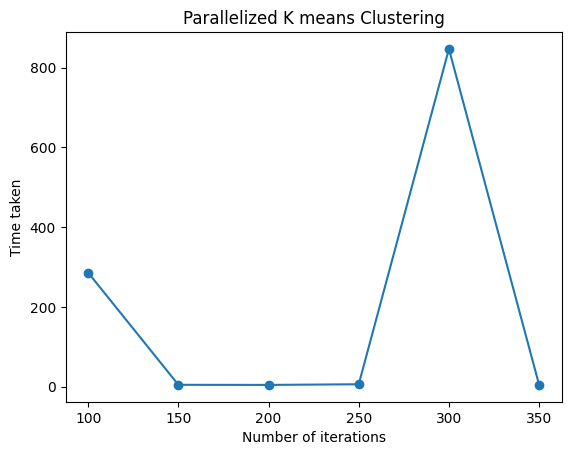

In [ ]:
X = data.to_numpy()[0:4]
itr = np.arange(100,400,50)
t_ser = []
t_par = []

for i in itr:
  t1 = time.time()
  KmeansSer = K_Means(3,i)
  y = KmeansSer.fit(X)
  t2 = time.time() - t1
  t_ser.append(t2)

rdd = sc.parallelize(X)

for i in itr:
  t1 = time.time()
  print(f"iteration - {i}")
  new_centro, assigned_clusters = custom_kmeans(n_clusters = 3,data=rdd, maxIter=i)
  t2 = time.time() - t1
  t_par.append(t2)

plt.plot(itr,t_ser,'-o')
plt.title('Sequential K means Clustering')
plt.xlabel('Number of iterations')
plt.ylabel('Time taken')
plt.show()

plt.plot(itr,t_par,'-o')
plt.title('Parallelized K means Clustering')
plt.xlabel('Number of iterations')
plt.ylabel('Time taken')
plt.show()

In [ ]:
X = data.to_numpy()

t1 = time.time()
KmeansSer = K_Means(3,700)
y = KmeansSer.fit(X)
t2 = time.time() - t1
data['Label_Seq'] = y.labels_

t3 = time.time()
rdd = sc.parallelize(X)
new_centro, assigned_clusters = custom_kmeans(n_clusters = 3,data=rdd, maxIter=700)
t4 = time.time() - t3
data['Label_Par'] = assigned_clusters.collect()

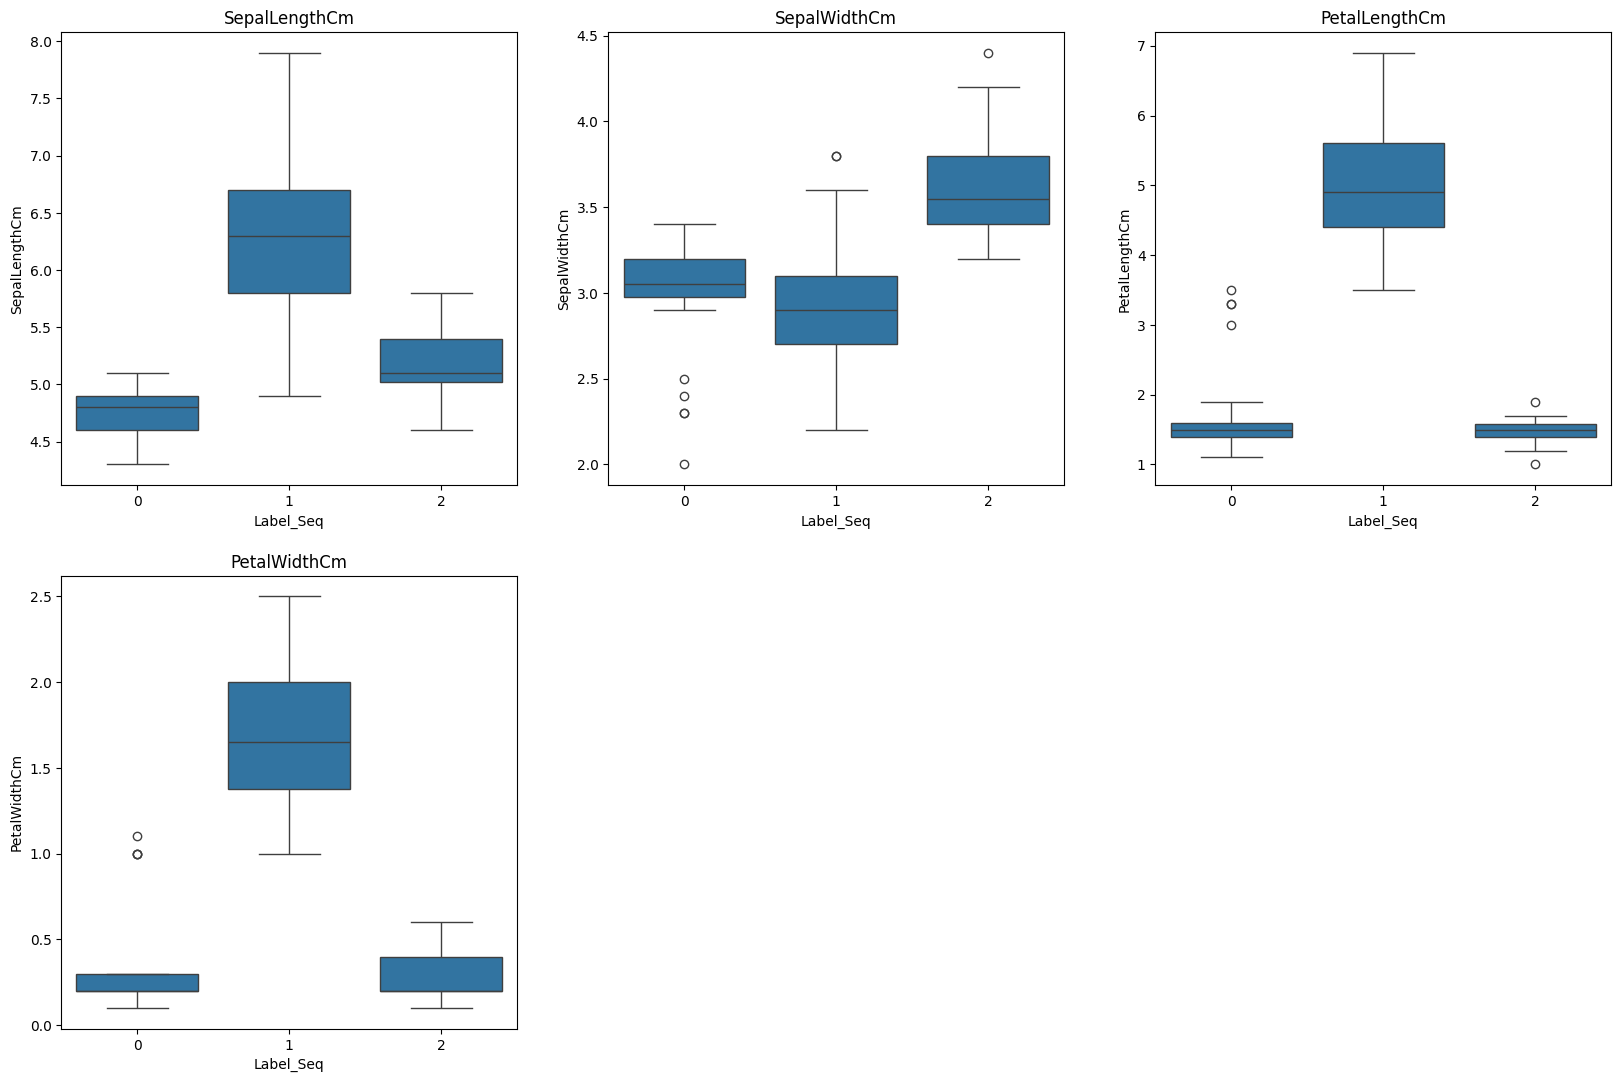

In [ ]:
l=['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
plt.figure(figsize=(20,20))
for i in range(len(l)):
    plt.subplot(3,3,i+1)
    sns.boxplot(x=data['Label_Seq'],y=data[l[i]])
    plt.title(l[i])

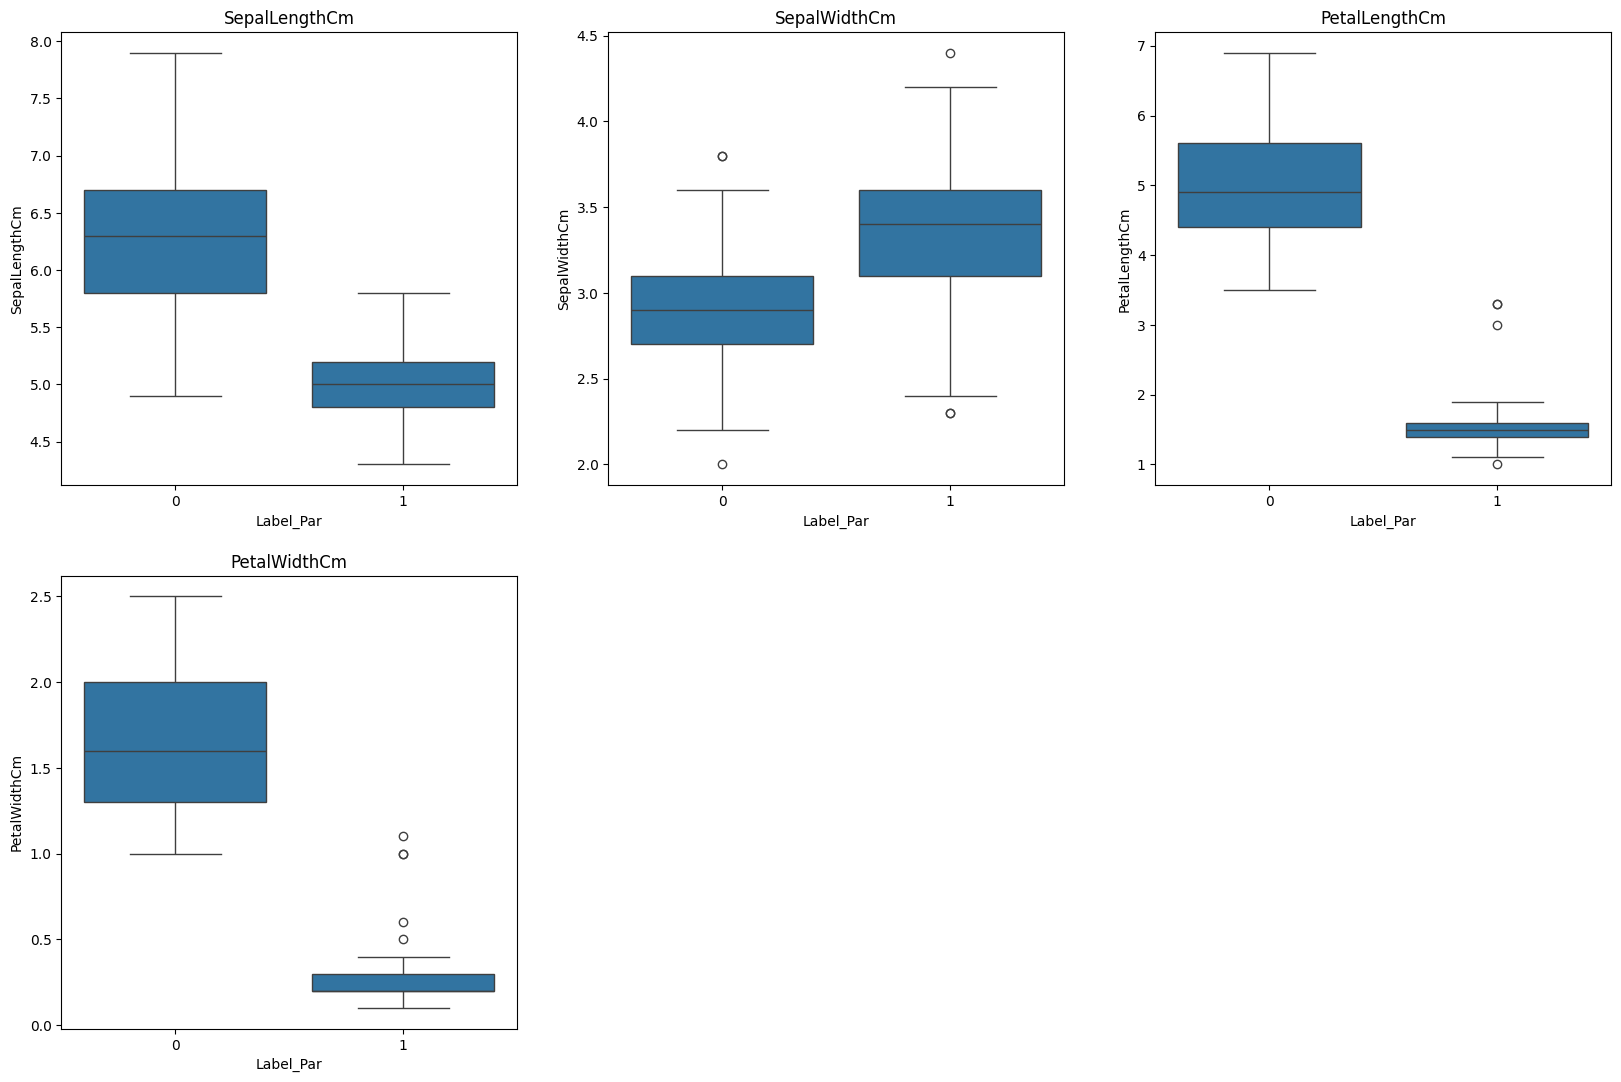

In [ ]:
l=['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
plt.figure(figsize=(20,20))
for i in range(len(l)):
    plt.subplot(3,3,i+1)
    sns.boxplot(x=data['Label_Par'],y=data[l[i]])
    plt.title(l[i])

In [ ]:
from sklearn import metrics

print("Performance of Sequential algorithm : ",metrics.silhouette_score(X,data['Label_Seq']))
print("Performance of Parallel algorithm : ",metrics.silhouette_score(X,data['Label_Par']))

Performance of Sequential algorithm :  0.5167485444533739
Performance of Parallel algorithm :  0.6808136202936816


## Clustering Analysis

In [ ]:
cluster_averages = data.groupby('Label_Par').agg({
    'SepalLengthCm': 'mean',
    'SepalWidthCm': 'mean',
    'PetalLengthCm': 'mean',
    'PetalWidthCm': 'mean'
}).reset_index()

print(cluster_averages.sort_values(by=['PetalLengthCm', 'PetalWidthCm'], ascending=False))


   Label_Par  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
0          0       6.301031      2.886598       4.958763      1.695876
1          1       5.005660      3.360377       1.562264      0.288679


In [ ]:
import plotly.express as px
!pip install -U kaleido
import kaleido

In [ ]:
data['Cluster_Label_Descriptive'] = data['Label_Par'].replace({
    0: 'Short Sepals and Petals',
    1: 'Long Petals',
    2: 'Medium Sepals and Petals'
})

In [ ]:
iris_data = pd.read_csv(input)

iris_data['cluster'] = data['Label_Par']

In [ ]:
iris_data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,cluster
0,1,5.1,3.5,1.4,0.2,Iris-setosa,1
1,2,4.9,3.0,1.4,0.2,Iris-setosa,1
2,3,4.7,3.2,1.3,0.2,Iris-setosa,1
3,4,4.6,3.1,1.5,0.2,Iris-setosa,1
4,5,5.0,3.6,1.4,0.2,Iris-setosa,1


In [ ]:
import plotly.express as px
from sklearn.decomposition import PCA
from google.colab import files

# Applying PCA for 2D projection
pca = PCA(n_components=2)
data['PCA1'], data['PCA2'] = pca.fit_transform(data[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']]).T

# Plot the 2D projection
fig = px.scatter(data, x='PCA1', y='PCA2', color='Cluster_Label_Descriptive',
                 title='Iris Clustering Map',
                 color_discrete_map={
                     'Short Sepals and Petals': 'red',
                     'Long Petals': 'green',
                     'Medium Sepals and Petals': 'blue'
                 },
                 hover_data=['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm'])

fig.update_layout(legend_title_text='Cluster Labels', title_y=0.95)
fig.write_html("plot.html")
print("HTML file saved! Open 'plot.html' in your browser to view the plot.")
files.download("plot.html")



HTML file saved! Open 'plot.html' in your browser to view the plot.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>